In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import argparse
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

np.random.seed(1)
print ("cargo")

/root/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


cargo


In [2]:
def datos():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)
    print ("Dimensiones train")
    print (mnist.train.images.shape)
    print ("Dimensiones test")
    print (mnist.test.images.shape)
    print ("cargo")
    X_train_o = mnist.train.images[:55000,:]
    Y_train_o = mnist.train.labels[:55000,:]
    X_test_o = mnist.test.images[:10000,:]
    Y_test_o = mnist.test.labels[:10000,:]
    print ("Dimensiones X train")
    print (X_train_o.shape)
    print ("Dimensiones Y train")
    print (Y_train_o.shape)
    print ("Las dimensiones de X son Nx por M, donde Nx son las caracteristicas y M es el numero, por eso hay que trasponerlo")
    X_train=X_train_o.T
    Y_train=Y_train_o.T
    print ("........")
    print ("X train transpuesto", str(X_train.shape))
    print ("Y train transpuesto", str(Y_train.shape))
    X_test=X_test_o.T
    Y_test=Y_test_o.T
    print ("X test transpuesto", str(X_test.shape))
    print ("Y test transpuesto", str(Y_test.shape))
    
    return X_train, Y_train, X_test, Y_test

In [3]:
def create_placeholders(n_x, n_y):
    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32,shape=(n_x, None),name="X")
    Y = tf.placeholder(tf.float32,shape=(n_y, None),name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [4]:
def initialize_parameters(n_x,n_y):
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 =  tf.get_variable("W1", [25,n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 =  tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 =  tf.get_variable("W3", [n_y,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n_y,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [5]:
def forward_propagation(X, parameters):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                               # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                             # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [6]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
%%time
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    #print (n_x)
    #print (m)
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    ### inicializar los parametros y la arquitectura de la red
    parameters = initialize_parameters(n_x,n_y)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3,Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    ##### Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            #print ("mini "+str(num_minibatches))
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
  

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions, xq no recibe a3. Claro no lo tengo. ¿como sabe que debe calcularlo?
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        '''
        print ("Train Accuracy:", sess.run(accuracy, feed_dict ={X: X_train, Y: Y_train})

        print ("Test Accuracy:", sess.run(accuracy, feed_dict ={X: X_test, Y: Y_test})
        
        '''
        return parameters

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [9]:
X_train, Y_train, X_test, Y_test = datos()

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Dimensiones train
(55000, 784)
Dimensiones test
(10000, 784)
cargo
Dimensiones X train
(55000, 784)
Dimensiones Y train
(55000, 10)
Las dimensiones de X son Nx por M, donde Nx son las caracteristicas y M es el numero, por eso hay que trasponerlo
........
X train transpuesto (784, 55000)
Y train transpuesto (10, 55000)
X test transpuesto (784, 10000)
Y test transpuesto (10, 10000)


Cost after epoch 0: 1.426199
Cost after epoch 100: 0.066361
Cost after epoch 200: 0.030645
Cost after epoch 300: 0.011905
Cost after epoch 400: 0.003304
Cost after epoch 500: 0.000741
Cost after epoch 600: 0.000130
Cost after epoch 700: 0.000130
Cost after epoch 800: 0.000020
Cost after epoch 900: 0.000013


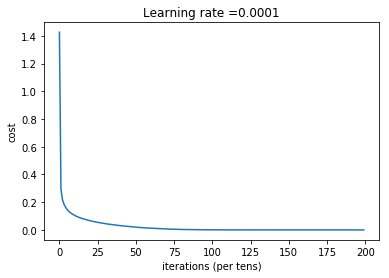

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.9559
CPU times: user 40min 1s, sys: 2min 7s, total: 42min 8s
Wall time: 26min 8s


In [10]:
%%time
parameters = model(X_train, Y_train, X_test, Y_test)

In [36]:
array=np.random.randint(55000, size=10)
for i in array:
    print (i)
    print(y_train[i].argmax(axis=0))
    image = x_train[i].reshape([28,28])
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

print (image)

2759


NameError: name 'y_train' is not defined